<h1><center>CSE521 Big Data Analytics</center></h1>
<br>
<h2><center>Flight Data Analysis using Apache Spark</center></h1>
<br>
<h2><left>Group Member</left></h2>
<h3><left>AU1940206 - Maulikkumar Bhalani</left></h2>
<h3><left>AU1940127 - Jay Ghetia</left></h2>
<h3><left>AU1940121 - Jinil Chandarana</left></h2>

## Installing SPARK in Google Colab

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

!pip install -q findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
import findspark 
findspark.init() 
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
# Import the spark session and establish environment

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)

In [ ]:
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import pyarrow as pa
from pyarrow import csv
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
textFile = sc.textFile("drive/MyDrive/bda_project/December_Flight_Dataset.csv")
textFile_may = sc.textFile("drive/MyDrive/bda_project/May_Flight_Dataset.csv")

In [ ]:
# Flight data for the month of December
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()
textRDD = textFileRDD.filter(lambda r: r != header)


# Flight data for the month of December
textFileRDD_may = textFile_may.map(lambda x: x.split(','))
header = textFileRDD_may.first()
textRDD_may = textFileRDD_may.filter(lambda r: r != header)

In [ ]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[8])), \
          CRSDepTime=int(r[7]),\
          ArrTime=int(float(r[11])),\
          CRSArrTime=int(r[10]), \
          UniqueCarrier=r[4],\
          DepDelay=int(float(r[9])),\
          Origin=r[5],\
          Dest=r[6], \
          Distance=int(float(r[12])),\
          CarrierDelay=int(float(r[13])),\
          WeatherDelay=int(float(r[14])),\
          NASDelay= int(float(r[15])),\
          SecurityDelay=int(float(r[16])),\
          LateAircraftDelay=int(float(r[17])))  
    except:
        x=None  
    return x

#Data for December
rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df = sqlContext.createDataFrame(rowRDD)


#Data for May
rowRDD_may = textRDD_may.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df_may = sqlContext.createDataFrame(rowRDD_may)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
# Data for December
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)


In [ ]:
#Data for May
airline_df_may = airline_df_may.withColumn('DepDelayed', airline_df_may['DepDelay']>15)

In [ ]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
sqlContext.udf.register("hour_ex_py",hour_ex, IntegerType())
f_udf = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f_udf(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


In [ ]:

#Data for May
#CRSDepTime: scheduled departure time (local, hhmm)
airline_df_may = airline_df_may.withColumn('hour', f_udf(airline_df_may.CRSDepTime))
airline_df_may.registerTempTable("airlineDF_may")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


In [ ]:
print("For Month December:")
#Data for December
airline_df.head(n=5)


For Month December:


[Row(Year=2014, Month=12, DayofMonth=9, DayOfWeek=2, DepTime=1113, CRSDepTime=1050, ArrTime=1329, CRSArrTime=1310, UniqueCarrier='AA', DepDelay=23, Origin='DFW', Dest='MSP', Distance=852, CarrierDelay=0, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=19, DepDelayed=True, hour=10),
 Row(Year=2014, Month=12, DayofMonth=12, DayOfWeek=5, DepTime=1057, CRSDepTime=1050, ArrTime=1332, CRSArrTime=1310, UniqueCarrier='AA', DepDelay=7, Origin='DFW', Dest='MSP', Distance=852, CarrierDelay=2, WeatherDelay=0, NASDelay=15, SecurityDelay=0, LateAircraftDelay=5, DepDelayed=False, hour=10),
 Row(Year=2014, Month=12, DayofMonth=20, DayOfWeek=6, DepTime=1143, CRSDepTime=1050, ArrTime=1400, CRSArrTime=1310, UniqueCarrier='AA', DepDelay=53, Origin='DFW', Dest='MSP', Distance=852, CarrierDelay=3, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=47, DepDelayed=True, hour=10),
 Row(Year=2014, Month=12, DayofMonth=22, DayOfWeek=1, DepTime=1105, CRSDepTime=1050, ArrTime=1330, CRSAr

In [ ]:
print("For Month May:")
#Data for May
airline_df_may.head(n=5)

For Month May:


[Row(Year=2014, Month=6, DayofMonth=6, DayOfWeek=5, DepTime=2255, CRSDepTime=855, ArrTime=49, CRSArrTime=1039, UniqueCarrier='AS', DepDelay=840, Origin='DEN', Dest='SEA', Distance=1024, CarrierDelay=840, WeatherDelay=0, NASDelay=10, SecurityDelay=0, LateAircraftDelay=0, DepDelayed=True, hour=8),
 Row(Year=2014, Month=6, DayofMonth=6, DayOfWeek=5, DepTime=1848, CRSDepTime=1835, ArrTime=2040, CRSArrTime=2015, UniqueCarrier='AS', DepDelay=13, Origin='DEN', Dest='SEA', Distance=1024, CarrierDelay=13, WeatherDelay=0, NASDelay=12, SecurityDelay=0, LateAircraftDelay=0, DepDelayed=False, hour=18),
 Row(Year=2014, Month=6, DayofMonth=6, DayOfWeek=5, DepTime=721, CRSDepTime=700, ArrTime=1036, CRSArrTime=1010, UniqueCarrier='AS', DepDelay=21, Origin='BOS', Dest='SEA', Distance=2496, CarrierDelay=21, WeatherDelay=0, NASDelay=5, SecurityDelay=0, LateAircraftDelay=0, DepDelayed=True, hour=7),
 Row(Year=2014, Month=6, DayofMonth=6, DayOfWeek=5, DepTime=1123, CRSDepTime=950, ArrTime=1342, CRSArrTime=1

In [ ]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF ")

In [ ]:
cause_delay_may = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF_may ")

In [ ]:
#For DECEMBER Month:
df_cause_delay = cause_delay.toPandas()
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,141765,1416790,7130,2519320,1866220


In [ ]:
# For MAY Month:
df_cause_delay_may = cause_delay_may.toPandas()
df_cause_delay_may.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,379880,1788826,6428,3405382,2174769


In [ ]:
print("For December:")
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()
df_origin.sort_values('delay',ascending=0).head()

For December:


,Origin,conFlight,delay
89,BJI,6,143.500000
20,MQT,9,130.888889
197,GUC,25,124.960000
33,HLN,9,119.222222
72,RDD,29,114.413793


In [ ]:
groupedDelay_may = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF_may \
                                GROUP BY Origin")

df_origin_may = groupedDelay_may.toPandas()
df_origin_may.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay
196,EKO,6,189.833333
290,WYS,3,179.000000
55,CEC,21,127.904762
255,ROW,24,113.250000
188,ABE,2,111.500000


In [ ]:
# For December:
df = pd.read_csv('drive/MyDrive/bda_project/airports.dat', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz','air','Ourair'], \
            header=0)
del df['air']
del df['Ourair']
df.head()

,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby


In [ ]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')
df_airports.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
0,INL,13,41.692308,Falls International Airport,International Falls,United States,INL,KINL,48.566200,-93.403099,1185,-6,A,America/Chicago
1,PSE,2,38.500000,Mercedita Airport,Ponce,Puerto Rico,PSE,TJPS,18.008301,-66.563004,29,-4,U,America/Puerto_Rico
2,MSY,558,61.973118,Louis Armstrong New Orleans International Airport,New Orleans,United States,MSY,KMSY,29.993401,-90.258003,4,-6,A,America/Chicago
3,PPG,3,28.666667,Pago Pago International Airport,Pago Pago,American Samoa,PPG,NSTU,-14.331000,-170.710007,32,-11,U,Pacific/Pago_Pago
4,GEG,152,52.118421,Spokane International Airport,Spokane,United States,GEG,KGEG,47.619900,-117.533997,2376,-8,A,America/Los_Angeles


In [ ]:
df_airports_may = pd.merge(df_origin_may, df, left_on = 'Origin', right_on = 'IATA')
df_airports_may.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
0,DLG,8,53.625000,Dillingham Airport,Dillingham,United States,DLG,PADL,59.044701,-158.505005,81,-9,A,America/Anchorage
1,PSE,9,47.777778,Mercedita Airport,Ponce,Puerto Rico,PSE,TJPS,18.008301,-66.563004,29,-4,U,America/Puerto_Rico
2,INL,13,55.384615,Falls International Airport,International Falls,United States,INL,KINL,48.566200,-93.403099,1185,-6,A,America/Chicago
3,MSY,913,57.401972,Louis Armstrong New Orleans International Airport,New Orleans,United States,MSY,KMSY,29.993401,-90.258003,4,-6,A,America/Chicago
4,PPG,2,7.000000,Pago Pago International Airport,Pago Pago,American Samoa,PPG,NSTU,-14.331000,-170.710007,32,-11,U,Pacific/Pago_Pago


In [ ]:
df_airports.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
89,BJI,6,143.500000,Bemidji Regional Airport,Bemidji,United States,BJI,KBJI,47.509399,-94.933701,1391,-6,A,America/Chicago
20,MQT,9,130.888889,Sawyer International Airport,Gwinn,United States,MQT,KSAW,46.353600,-87.395401,1221,-5,A,America/New_York
197,GUC,25,124.960000,Gunnison Crested Butte Regional Airport,Gunnison,United States,GUC,KGUC,38.533901,-106.932999,7680,-7,A,America/Denver
33,HLN,9,119.222222,Helena Regional Airport,Helena,United States,HLN,KHLN,46.606800,-111.983002,3877,-7,A,America/Denver
72,RDD,29,114.413793,Redding Municipal Airport,Redding,United States,RDD,KRDD,40.508999,-122.292999,505,-8,A,America/Los_Angeles


In [ ]:
df_airports_may.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
196,EKO,6,189.833333,Elko Regional Airport,Elko,United States,EKO,KEKO,40.824902,-115.792000,5140,-8,A,America/Los_Angeles
290,WYS,3,179.000000,Yellowstone Airport,West Yellowstone,United States,WYS,KWYS,44.688400,-111.117996,6649,-7,A,America/Denver
55,CEC,21,127.904762,Jack Mc Namara Field Airport,Crescent City,United States,CEC,KCEC,41.780201,-124.236999,61,-8,A,America/Los_Angeles
255,ROW,24,113.250000,Roswell International Air Center Airport,Roswell,United States,ROW,KROW,33.301601,-104.530998,3671,-7,A,America/Denver
188,ABE,2,111.500000,Lehigh Valley International Airport,Allentown,United States,ABE,KABE,40.652100,-75.440804,393,-5,A,America/New_York


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

In [ ]:
#import os
#os.environ['PROJ_LIB'] = r'C:\ProgramData\Anaconda3\Library\share\mpl_toolkits.clifford-0.0.3-py3-none-any'

In [ ]:
!pip install git+https://github.com/matplotlib/basemap#subdirectory=packages/basemap

  Cloning https://github.com/matplotlib/basemap to /tmp/pip-req-build-s29o25ft
  Running command git clone -q https://github.com/matplotlib/basemap /tmp/pip-req-build-s29o25ft
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
ERROR: File "setup.py" not found for legacy project https://github.com/matplotlib/basemap/archive/master.zip.


In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

In [ ]:
rcParams['figure.figsize'] = (14,10)


Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


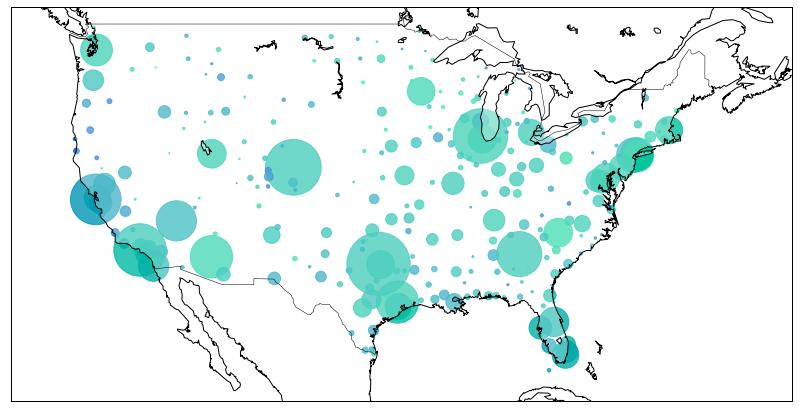

In [ ]:
# For December:
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('winter')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>60000) & (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


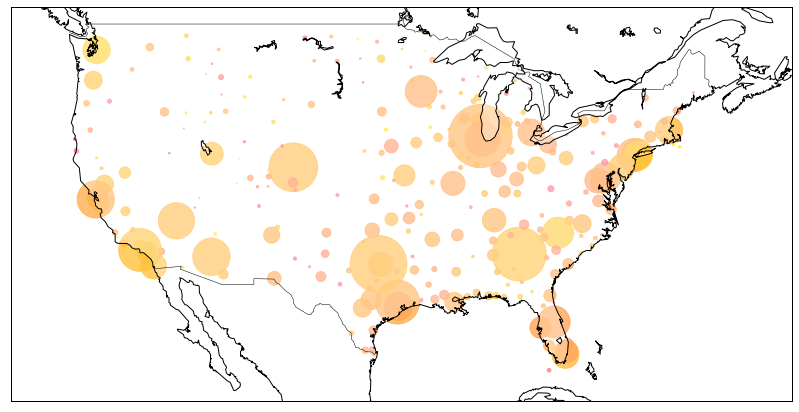

In [ ]:
# For July:
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('spring')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports_may['conFlight'])-min(df_airports_may['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports_may['delay'])])
xs,ys = my_map(np.asarray(df_airports_may['lng']), np.asarray(df_airports_may['lat']))
val=df_airports_may['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports_may[(df_airports_may['conFlight']>60000) & (df_airports_may['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

In [ ]:
# For December
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()

In [ ]:
# For May
grp_rout_Delay_may = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF_may \
                                GROUP BY Origin,Dest")
rout_Delay_may = grp_rout_Delay_may.toPandas()

In [ ]:
# For December
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]
df_airport_rout.sort_values('avgDelay',ascending=0).head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
1286,JAC,43.607300,-110.737999,ATL,33.636700,-84.428101,421.666667,3
743,PSP,33.829700,-116.507004,MSP,44.882000,-93.221802,372.333333,3
2540,JFK,40.639801,-73.778900,EGE,39.642601,-106.917999,367.200000,5
705,HLN,46.606800,-111.983002,DEN,39.861698,-104.672997,343.500000,2
786,RDU,35.877602,-78.787498,MSP,44.882000,-93.221802,314.000000,4


In [ ]:
# For May
df_airport_rout1_may = pd.merge(rout_Delay_may, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2_may = pd.merge(df_airport_rout1_may, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout_may = df_airport_rout2_may[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]
df_airport_rout_may.sort_values('avgDelay',ascending=0).head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
1708,TVC,44.741402,-85.582199,LGA,40.777199,-73.872597,337.5,2
771,JAC,43.607300,-110.737999,MSP,44.882000,-93.221802,322.0,1
2951,EWR,40.692501,-74.168701,ALB,42.748299,-73.801697,310.0,1
1045,PVD,41.732601,-71.420403,IAD,38.944500,-77.455803,308.0,2
2111,ALB,42.748299,-73.801697,EWR,40.692501,-74.168701,301.0,1


Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


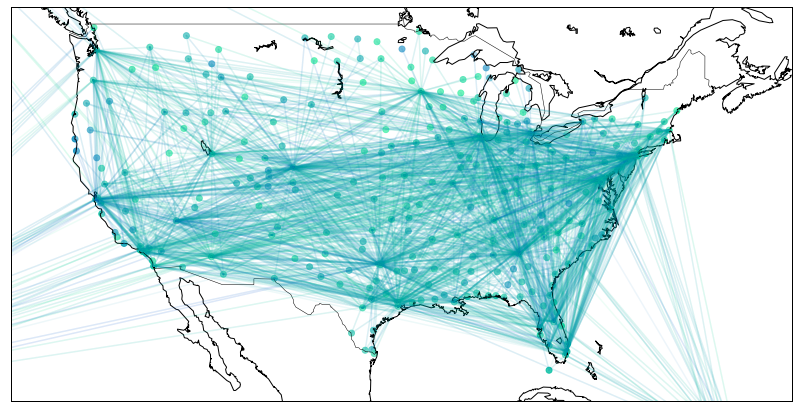

In [ ]:
# For December
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('winter')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()

Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


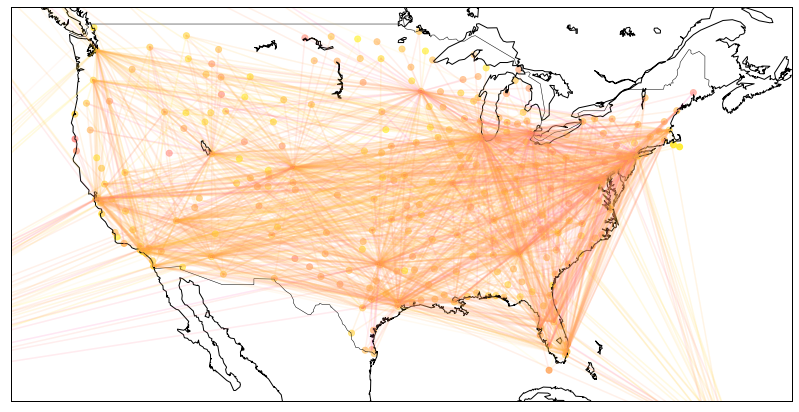

In [ ]:
#For May
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports_may["delay"])])
colors = plt.get_cmap('spring')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports_may['lng']), np.asarray(df_airports_may['lat']))
xo,yo = my_map(np.asarray(df_airport_rout_may['lng_x']), np.asarray(df_airport_rout_may['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout_may['lng_y']), np.asarray(df_airport_rout_may['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout_may["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout_may['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()

#Exploration : Airport Origin delay per month
  

In [ ]:
Origin_Airport="SJC"


In [ ]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
|   2107|      2031|      1850|        2|         2|      43|   1933| PDX|
|   1604|      1539|      1355|        2|         2|      37|   1432| PDX|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



In [ ]:
print("total flights from this ariport: " + str(df_ORG.count()))

total flights from this ariport: 968


In [ ]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [ ]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]


Text(0.5, 1.0, 'How much delay does each carrier has in each month?')

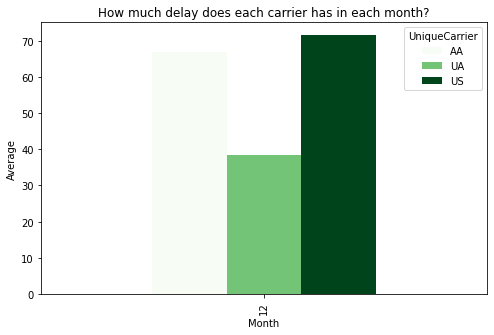

In [ ]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Month')
plt.ylabel('Average')
plt.title('How much delay does each carrier has in each month?')

#Airport Origin delay per day/hour
  

In [ ]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')


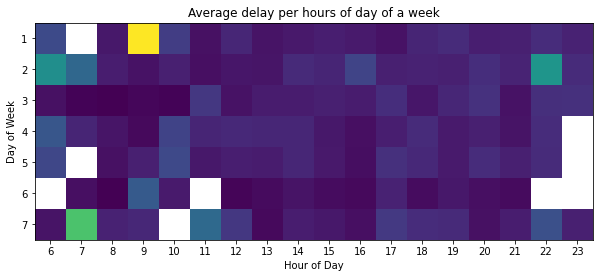

In [ ]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours of day of a week')
plt.imshow(Z)

In [ ]:
Origin_Airport="SJC"

In [ ]:
df_ORG=sqlContext.sql("SELECT * from airlineDF WHERE Origin = '"+Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")

##Modeling: Logistic Regression


In [ ]:
#feature selction
df_model=df_ORG
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)
encoder1 = OneHotEncoder(dropLast=False,inputCol="originIndex", outputCol="originVec")
ohe = encoder1.fit(indexedOrigin)
df_model = ohe.transform(indexedOrigin)

In [ ]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','originVec'],
    outputCol = "features")
output = assembler.transform(df_model)

In [ ]:
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg
from pyspark.sql.functions import col
def as_old(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Unsupported type {0}".format(type(v)))
airlineRDD=output.select(col("DepDelayed").alias("label"), col("features"))\
            .rdd\
            .map(lambda row: LabeledPoint(row.label, as_old(row.features)))

In [ ]:
#  Spliting dataset into train and test dtasets
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])

In [ ]:
# Build the model
model = LogisticRegressionWithLBFGS.train(trainRDD)

##Model Evaluation


In [ ]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))
labelsAndPreds.take(2)

[(1.0, 1), (1.0, 1)]

In [ ]:
trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(testRDD.count())
print("Training Error = " + str(trainErr))

Training Error = 0.15202702702702703


In [ ]:
testRDD.take(10)

[LabeledPoint(1.0, [2014.0,12.0,2.0,2.0,18.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,2.0,2.0,13.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,4.0,4.0,8.0,2355.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,5.0,5.0,10.0,697.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,7.0,7.0,9.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,7.0,7.0,13.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,23.0,2.0,15.0,697.0,1.0]),
 LabeledPoint(0.0, [2014.0,12.0,23.0,2.0,18.0,697.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,23.0,2.0,8.0,2355.0,1.0]),
 LabeledPoint(0.0, [2014.0,12.0,26.0,5.0,18.0,697.0,1.0])]

In [ ]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda vp: ((vp[1], vp[0]), 1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [ ]:
for x in range(len(acc)): 
    print (acc[x])

('TP', 244)
('FP', 5)
('FN', 40)
('TN', 7)


# Accuracy of the model

In [ ]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print("Model Accuracy for SJC:")
print(float(Accuracy*100))

Model Accuracy for SJC:
84.7972972972973
